# Using the Google Geocoding API to geolocate METAR data

## What is Geocoding?
 * Translate physical addresses to geographic coordinates
 * Access via a web services call
 * Returns either XML or JSON formatted data
 * [https://developers.google.com/maps/documentation/geocoding/](https://developers.google.com/maps/documentation/geocoding/)
    
## What is METAR?
 * Surface observational data
 * Access via a URL constructed from a web form
 * Returns csv, xml, or NetCDF formatted data
 * [http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.html?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr](http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.html?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr)

## Import useful libraries that (other) people have written
 * We need a library to understand URLs and XML documents -> ElementTree
 * We need to be able to access documents from the web -> urllib
 * We will be working with dates and time -> datetime

In [1]:
%matplotlib inline

import urllib
#import numpy as np
import xml.etree.ElementTree as ET

from datetime import datetime, timedelta

## Google Geocoding API
 * Recall - this turns a street address into a latitude and longitude

In [2]:
gcBaseURL='http://maps.googleapis.com/maps/api/geocode/xml?'

## Populate an address in human readable form

In [3]:
address = '3300 Mitchell Lane, Boulder, CO'
#address = 'South Pole'
#address = '1817 Pineapple Ave., Melbourne, FL'
#address = '708 N. Harvard Ave., Ventnor Heights, NJ'
print(address)

3300 Mitchell Lane, Boulder, CO


## Our address needs to look more like what the Google API expects
 * No spaces in the address
 * Simple string manipulation

In [4]:
address = address.replace(' ','+')
print(address)

3300+Mitchell+Lane,+Boulder,+CO


## Now let's construct the URL
 * Set up the sensor component
 * Assemble the URL
 * Do a sanity check

In [5]:
gcParameters='address={}&sensor=false'.format(address)
gcURL = gcBaseURL + gcParameters
print(gcURL)

http://maps.googleapis.com/maps/api/geocode/xml?address=3300+Mitchell+Lane,+Boulder,+CO&sensor=false


## Visit the link above...now whatta-huh?
 * Back to our libraries to decode the XML
 * "Walk the DOM" to get to lat and lon
 * http://en.wikipedia.org/wiki/Document_Object_Model

In [6]:
tree = ET.parse(urllib.request.urlopen(gcURL))
root = tree.getroot()

for result in root.findall('result'):
    for geometry in result.findall('geometry'):
        for location in geometry.findall('location'):
            lat = location.find('lat').text
            lon = location.find('lng').text
        
print('lat, lon -> {}, {}'.format(lat, lon))

lat, lon -> 40.0349700, -105.2432010


## Construct our request to the TDS using the expected base URL and our query string
 * Open your browser and go to http://thredds.ucar.edu/thredds/catalog.html
 * Find METR data under "Observation Data/"
 * Go to the METR dataset called "Feature Collection" - this is the THREDDS catalog in html form
 * In the url, change ".html" to ".xml" - this is actual THREDDS Catalog. The THREDDS catalog tells you what data is available and how it can be accessed.
 * We will use the Unidata python library "siphon" to read the catalog and access the actual METR data.

In [7]:
from siphon.catalog import TDSCatalog
# copied from the browser url box
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
# parse the xml
metar_cat = TDSCatalog(metar_cat_url)
# what datasets are here? only one "dataset" in this catalog
dataset = list(metar_cat.datasets.values())[0]
print(dataset.name)

Feature Collection


## What kind of access methods are available?

In [8]:
print(list(dataset.access_urls.keys()))

['NetcdfSubset']


## NetcdfSubset it is!

In [9]:
ncss_url = dataset.access_urls["NetcdfSubset"]

## Ok...but what is NetcdfSubset
 * A web service for subsetting CDM scientific datasets
   * Like the Google Geocoding API, construct a URL for requst (RESTfull API)
 * The subsetting is specified using earth coordinates
  * lat/lon or projection coordinates, bounding boxes, date ranges
  * <b>Not</b> index based!
 * Check out the details in your browser: http://www.unidata.ucar.edu/software/thredds/v4.6/tds/reference/NetcdfSubsetServiceReference.html
 * Rather than construct the request "by hand", as we did with the Google Geocoding API, let's use siphon!

In [10]:
from siphon.ncss import NCSS
ncss = NCSS(ncss_url)

## Whaddua want?
* Let's say we want the past days worth of data...
* ...for "here" (i.e. the lat/lon we obtained using the Google Geocoding API)
* ...for the variables mean sea level pressure, air temperature,wind direction, and wind_speed
* ...and for fun, let's get the data back as a netCDF file

In [11]:
# get current date and time
now = datetime.utcnow() - timedelta(days=5)
now = datetime(now.year, now.month, now.day, now.hour)

# define the time range we are interested in
start_time = now - timedelta(days=1)
end_time = now

# build the query
query = ncss.query()
query.lonlat_point(lon, lat)
query.time_range(start_time, end_time)
query.variables('air_pressure_at_sea_level','air_temperature','wind_from_direction','wind_speed')
query.accept('netcdf')

# what does the request url look like?
print(query)

var=wind_from_direction&var=air_pressure_at_sea_level&var=wind_speed&var=air_temperature&time_end=2015-07-11T02%3A00%3A00&time_start=2015-07-10T02%3A00%3A00&longitude=-105.2432010&latitude=40.0349700&accept=netcdf


## Let's get the data!

In [12]:
data = ncss.get_data(query)

## What did we get back?
 * That's right, a netcdf4-python dataset!
 * Is that what you expected?

In [13]:
print(list(data.variables.keys()))

['latitude', 'longitude', 'stationAltitude', 'station_id', 'station_description', 'wmo_id', 'time', 'stationIndex', 'wind_from_direction', 'wind_speed', 'air_temperature', 'air_pressure_at_sea_level']


## What station did we get?

In [14]:
station_id = data['station_id'][:].tostring()
print(station_id)

b'BJC'


## Notice anything funny?
 * the "b" means it's a byte encoded string
 * let's use something sane like, uhh, utf-8

In [15]:
station_id = station_id.decode("utf-8")
print(station_id)

BJC


## Let's get the time (in seconds since 1970-01-01) into a datetime object

In [16]:
time = [datetime.fromtimestamp(t) for t in data['time']]

##Now for the obligatory time series plot...

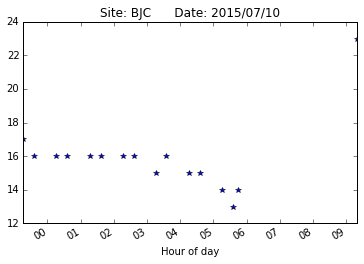

In [17]:
from matplotlib import pyplot as plt
from matplotlib.dates import HourLocator,DateFormatter, AutoDateLocator

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(time, data['air_temperature'], '*')

locator = AutoDateLocator()
hoursFmt = DateFormatter('%H')

ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(hoursFmt)
ax1.autoscale_view()
ax1.set_title('Site: {}      Date: {}'.format(station_id, time[0].strftime('%Y/%m/%d')))
ax1.set_xlabel('Hour of day')
#ax1.set_ylabel(t_air_label)
fig.autofmt_xdate()
plt.show()

## Now, let's request all stations within a bounding box for a given time and create a surface "station plot" map (sort-of)
 * Make new NCSS query
 * Request data closest to "now"
 * This time, let's ask for the data in csv format

In [18]:
bb = {'north' : 45,
      'south' : 35,
      'east' : -100,
      'west' : -110}

query = ncss.query()
query.lonlat_box(bb['north'], bb['south'], bb['east'], bb['west'])
query.time(start_time)
query.variables('air_temperature', 'dew_point_temperature')
query.accept('csv')

var=dew_point_temperature&var=air_temperature&time=2015-07-10T02%3A00%3A00&north=45&south=35&west=-110&east=-100&accept=csv

## Let's get the data!

In [19]:
data = ncss.get_data(query)

# Access is just like netcdf4-python
lats = data['latitude'][:]
lons = data['longitude'][:]
tair = data['air_temperature'][:]
dewp = data['dew_point_temperature'][:]

## This code is to facilitate station plots of the data
 * One day, MetPy will handle this
 * Let's just skip over this for now

In [20]:
from matplotlib import rcParams
from matplotlib.artist import Artist
from matplotlib.cbook import is_string_like
from matplotlib.text import Text
from matplotlib.font_manager import FontProperties
class TextCollection(Artist):
    def __init__(self,
                 x=0, y=0, text='',
                 color=None,          # defaults to rc params
                 verticalalignment='bottom',
                 horizontalalignment='left',
                 multialignment=None,
                 fontproperties=None, # defaults to FontProperties()
                 rotation=None,
                 linespacing=None,
                 **kwargs
                 ):

        Artist.__init__(self)
        if color is None:
            colors= rcParams['text.color']

        if fontproperties is None:
            fontproperties = FontProperties()
        elif is_string_like(fontproperties):
            fontproperties = FontProperties(fontproperties)

        self._animated = False
#        if is_string_like(text):
#            text = [text]

        self._textobjs = [Text(x[ind], y[ind], text[ind], color,
            verticalalignment, horizontalalignment, multialignment,
            fontproperties, rotation, linespacing, **kwargs)
            for ind in range(len(x))]

        self.update(kwargs)

    def draw(self, renderer):
        for t in self._textobjs:
            t.draw(renderer)

    def set_figure(self, fig):
        for t in self._textobjs:
            t.set_figure(fig)

    def is_transform_set(self):
        return all(t.is_transform_set() for t in self._textobjs)

    def get_transform(self):
        return self._textobjs[0].get_transform()

    def set_transform(self, trans):
        for t in self._textobjs:
            t.set_transform(trans)

    def set_clip_path(self, path):
        for t in self._textobjs:
            t.set_clip_path(path)

    def set_axes(self, ax):
        for t in self._textobjs:
            t.set_axes(ax)

def text_plot(ax, x, y, data, format='%.0f', loc=None, **kw):
    from matplotlib.cbook import delete_masked_points
    from matplotlib import transforms

    # Default to centered on point
    if 'transform' in kw:
        t = kw.pop('transform')
    else:
        t = ax.projection

    if loc is not None:
        x0,y0 = loc
        trans = t._as_mpl_transform(ax) + transforms.Affine2D().translate(x0, y0)
    else:
        trans = t._as_mpl_transform(ax)

    # Handle both callables and strings for format
    if is_string_like(format):
        formatter = lambda s: format % s
    else:
        formatter = format

    # Handle masked arrays
    x,y,data = delete_masked_points(x, y, data)

    # If there is nothing left after deleting the masked points, return None
    if not data.any():
        return None

    # Make the TextCollection object
    texts = [formatter(d) for d in data]
    text_obj = TextCollection(x, y, texts, horizontalalignment='center',
        verticalalignment='center', clip_on=True, transform=trans, **kw)
#        verticalalignment='center', clip_on=True, **kw)

    # Add it to the axes
    ax.add_artist(text_obj)

    # Update plot range
    minx = np.min(x)
    maxx = np.max(x)
    miny = np.min(y)
    maxy = np.max(y)
    w = maxx - minx
    h = maxy - miny

    # the pad is a little hack to deal with the fact that we don't
    # want to transform all the symbols whose scales are in points
    # to data coords to get the exact bounding box for efficiency
    # reasons.  It can be done right if this is deemed important
    padx, pady = 0.05*w, 0.05*h
    corners = (minx-padx, miny-pady), (maxx+padx, maxy+pady)
    ax.update_datalim(corners)
    ax.autoscale_view()
    return text_obj

## Create the map using cartopy and matplotlib!

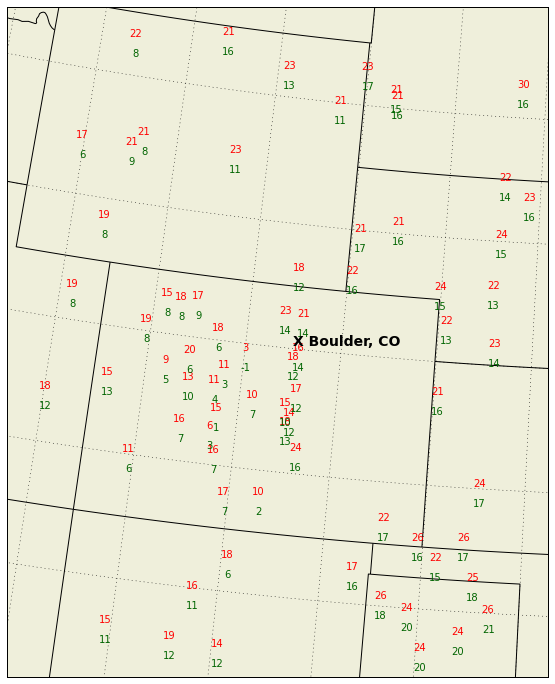

In [21]:
import cartopy
import numpy as np

fig = plt.figure(figsize=(24,12))
proj = cartopy.crs.Stereographic(central_longitude=-95, central_latitude=35)
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add map features
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.NaturalEarthFeature(category='cultural', 
                                                   name='admin_1_states_provinces_lines',
                                                   scale='50m',
                                                   facecolor='none'))
ax.add_feature(cartopy.feature.BORDERS)
ax.coastlines()
ax.gridlines()

# Set extent to match requested bounding box
ax.set_extent([bb['west'], bb['east'], bb['south'], bb['north']])

# Using above helpers, plot air temperature and dewpoint as in a station plot
text_plot(ax, lons, lats, tair, transform=cartopy.crs.PlateCarree(),
          zorder=5, color='red', loc=(-10, 10))
text_plot(ax, lons, lats, dewp, transform=cartopy.crs.PlateCarree(),
          zorder=5, color='darkgreen', loc=(-10, -10))
ax.text(-105, 40, "X Boulder, CO", transform=cartopy.crs.PlateCarree(), 
        zorder=6, fontsize=14, fontweight='bold', horizontalalignment="left",
        verticalalignment="bottom")